Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 50
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


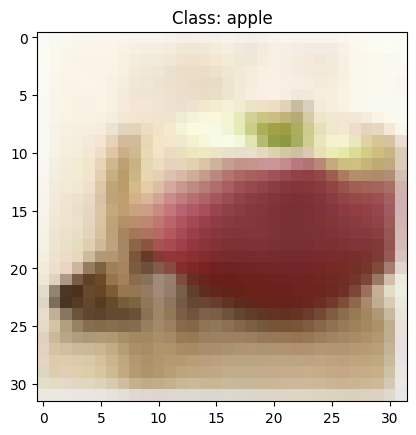

Sample input image class: boy


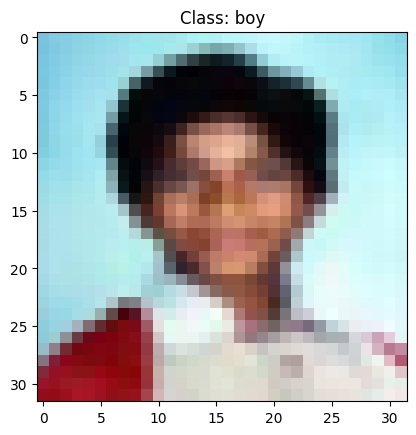

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout2D(dropout_rate)(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1, dropout_rate=0.3)
x = identity_block(x, 64, dropout_rate=0.3)


x = conv_block(x, 128, stride=2, dropout_rate=0.3)
x = identity_block(x, 128, dropout_rate=0.3)


x = conv_block(x, 256, stride=2, dropout_rate=0.3)
x = identity_block(x, 256, dropout_rate=0.3)


x = Dropout(0.2)(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ spatial_dropout2d[0][… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 2,811,940 (10.73 MB)

 Trainable params: 2,807,332 (10.71 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=6,
    min_lr=1e-5,
    mode='max',
    cooldown=2,
    verbose=1
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
        reduce_lr,
    ]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.0551 - loss: 4.3204
Epoch 1: val_accuracy improved from -inf to 0.01040, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 4.0192 - Training Accuracy: 0.0826
  Validation Loss: 10.1549 - Validation Accuracy: 0.0104
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.0553 - loss: 4.3185 - val_accuracy: 0.0104 - val_loss: 10.1549 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1580 - loss: 3.5251
Epoch 2: val_accuracy improved from 0.01040 to 0.01850, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 3.4069 - Training Accuracy: 0.1766
  Validation Loss: 7.6791 - Validation Accuracy: 0.0185
! Overfitting: 0.1581 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1581 - loss: 3.5243 - val_accuracy: 0.0185 - val_loss: 7.6791 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2341 - loss: 3.0811
Epoch 3: val_accuracy improved from 0.01850 to 0.09050, saving model to best_model.h5



Epoch 3
LR: 1.0e-03

  Training Loss: 2.9850 - Training Accuracy: 0.2519
  Validation Loss: 4.4148 - Validation Accuracy: 0.0905
! Overfitting: 0.1614 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2342 - loss: 3.0805 - val_accuracy: 0.0905 - val_loss: 4.4148 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3046 - loss: 2.7058
Epoch 4: val_accuracy improved from 0.09050 to 0.16520, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.6396 - Training Accuracy: 0.3181
  Validation Loss: 3.8441 - Validation Accuracy: 0.1652
! Overfitting: 0.1529 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3047 - loss: 2.7054 - val_accuracy: 0.1652 - val_loss: 3.8441 - learning_rate: 0.0010
Epoch 5/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3647 - loss: 2.4276
Epoch 5: val_accuracy improved from 0.16520 to 0.21000, saving model to best_model.h5



Epoch 5
LR: 1.0e-03

  Training Loss: 2.3748 - Training Accuracy: 0.3753
  Validation Loss: 3.7184 - Validation Accuracy: 0.2100
! Overfitting: 0.1653 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3649 - loss: 2.4269 - val_accuracy: 0.2100 - val_loss: 3.7184 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4138 - loss: 2.1986
Epoch 6: val_accuracy improved from 0.21000 to 0.28780, saving model to best_model.h5



Epoch 6
LR: 1.0e-03

  Training Loss: 2.1616 - Training Accuracy: 0.4201
  Validation Loss: 2.8957 - Validation Accuracy: 0.2878
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4138 - loss: 2.1984 - val_accuracy: 0.2878 - val_loss: 2.8957 - learning_rate: 0.0010
Epoch 7/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4544 - loss: 2.0101
Epoch 7: val_accuracy improved from 0.28780 to 0.37150, saving model to best_model.h5



Epoch 7
LR: 1.0e-03

  Training Loss: 1.9776 - Training Accuracy: 0.4618
  Validation Loss: 2.4592 - Validation Accuracy: 0.3715
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4545 - loss: 2.0095 - val_accuracy: 0.3715 - val_loss: 2.4592 - learning_rate: 0.0010
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4912 - loss: 1.8416
Epoch 8: val_accuracy did not improve from 0.37150

Epoch 8
LR: 1.0e-03

  Training Loss: 1.8233 - Training Accuracy: 0.4975
  Validation Loss: 3.2028 - Validation Accuracy: 0.2779
! Overfitting: 0.2196 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4913 - loss: 1.8415 - val_accuracy: 0.2779 - val_loss: 3.2028 - learning_rate: 0.0010
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5305 - loss: 1.6911
Epoch 9: val_accuracy did not improve from 0.37150

Epoch 9
LR: 1.0e-03

  Training Loss: 1.6932 - Training Accuracy: 0.5296
  Validation Loss: 3.1347 - Validation Accuracy: 0.3113
! Overfitting: 0.2183 ga


Epoch 12
LR: 1.0e-03

  Training Loss: 1.3616 - Training Accuracy: 0.6113
  Validation Loss: 2.3798 - Validation Accuracy: 0.4212
! Overfitting: 0.1901 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6123 - loss: 1.3633 - val_accuracy: 0.4212 - val_loss: 2.3798 - learning_rate: 0.0010
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6367 - loss: 1.2601
Epoch 13: val_accuracy did not improve from 0.42120

Epoch 13
LR: 1.0e-03

  Training Loss: 1.2670 - Training Accuracy: 0.6343
  Validation Loss: 2.5232 - Validation Accuracy: 0.3853
! Overfitting: 0.2490 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6367 - loss: 1.2601 - val_accuracy: 0.3853 - val_loss: 2.5232 - learning_rate: 0.0010
Epoch 14/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6576 - loss: 1.1703
Epoch 14: val_accuracy improved from 0.42120 to 0.42170, saving model to best_model.h5



Epoch 14
LR: 1.0e-03

  Training Loss: 1.1741 - Training Accuracy: 0.6571
  Validation Loss: 2.4031 - Validation Accuracy: 0.4217
! Overfitting: 0.2354 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6576 - loss: 1.1703 - val_accuracy: 0.4217 - val_loss: 2.4031 - learning_rate: 0.0010
Epoch 15/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6863 - loss: 1.0730
Epoch 15: val_accuracy improved from 0.42170 to 0.44330, saving model to best_model.h5



Epoch 15
LR: 1.0e-03

  Training Loss: 1.0878 - Training Accuracy: 0.6819
  Validation Loss: 2.2621 - Validation Accuracy: 0.4433
! Overfitting: 0.2386 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6862 - loss: 1.0732 - val_accuracy: 0.4433 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 16/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7086 - loss: 0.9923
Epoch 16: val_accuracy improved from 0.44330 to 0.44570, saving model to best_model.h5



Epoch 16
LR: 1.0e-03

  Training Loss: 1.0101 - Training Accuracy: 0.7007
  Validation Loss: 2.3397 - Validation Accuracy: 0.4457
! Overfitting: 0.2550 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7085 - loss: 0.9924 - val_accuracy: 0.4457 - val_loss: 2.3397 - learning_rate: 0.0010
Epoch 17/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7244 - loss: 0.9354
Epoch 17: val_accuracy did not improve from 0.44570

Epoch 17
LR: 1.0e-03

  Training Loss: 0.9375 - Training Accuracy: 0.7204
  Validation Loss: 2.6624 - Validation Accuracy: 0.4163
! Overfitting: 0.3041 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7244 - loss: 0.9354 - val_accuracy: 0.4163 - val_loss: 2.6624 - learning_rate: 0.0010
Epoch 18/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7469 - loss: 0.8383
Epoch 18: val_accuracy did not improve from 0.44570

Epoch 18
LR: 1.0e-03

  Training Loss: 0.8633 - Training Accuracy: 0.7400
  Validation Loss: 2.9500 - Validation Accuracy


Epoch 22
LR: 1.0e-03

  Training Loss: 0.5933 - Training Accuracy: 0.8169
  Validation Loss: 2.2548 - Validation Accuracy: 0.5080
! Overfitting: 0.3089 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8240 - loss: 0.5754 - val_accuracy: 0.5080 - val_loss: 2.2548 - learning_rate: 0.0010
Epoch 23/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8406 - loss: 0.5226
Epoch 23: val_accuracy did not improve from 0.50800

Epoch 23
LR: 1.0e-03

  Training Loss: 0.5344 - Training Accuracy: 0.8364
  Validation Loss: 3.0469 - Validation Accuracy: 0.4269
! Overfitting: 0.4095 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8405 - loss: 0.5228 - val_accuracy: 0.4269 - val_loss: 3.0469 - learning_rate: 0.0010
Epoch 24/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8535 - loss: 0.4802
Epoch 24: val_accuracy did not improve from 0.50800

Epoch 24
LR: 1.0e-03

  Training Loss: 0.4879 - Training Accuracy: 0.8497
  Validation Loss: 3.1531 - Validation Accuracy


Epoch 29
LR: 5.0e-04

  Training Loss: 0.1912 - Training Accuracy: 0.9476
  Validation Loss: 1.8944 - Validation Accuracy: 0.5733
! Overfitting: 0.3743 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9435 - loss: 0.2083 - val_accuracy: 0.5733 - val_loss: 1.8944 - learning_rate: 5.0000e-04
Epoch 30/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9626 - loss: 0.1501
Epoch 30: val_accuracy improved from 0.57330 to 0.59070, saving model to best_model.h5



Epoch 30
LR: 5.0e-04

  Training Loss: 0.1496 - Training Accuracy: 0.9630
  Validation Loss: 1.9137 - Validation Accuracy: 0.5907
! Overfitting: 0.3723 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9626 - loss: 0.1501 - val_accuracy: 0.5907 - val_loss: 1.9137 - learning_rate: 5.0000e-04
Epoch 31/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9706 - loss: 0.1260
Epoch 31: val_accuracy did not improve from 0.59070

Epoch 31
LR: 5.0e-04

  Training Loss: 0.1296 - Training Accuracy: 0.9686
  Validation Loss: 2.0753 - Validation Accuracy: 0.5729
! Overfitting: 0.3957 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9706 - loss: 0.1260 - val_accuracy: 0.5729 - val_loss: 2.0753 - learning_rate: 5.0000e-04
Epoch 32/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9733 - loss: 0.1142
Epoch 32: val_accuracy improved from 0.59070 to 0.59350, saving model to best_model.h5



Epoch 32
LR: 5.0e-04

  Training Loss: 0.1161 - Training Accuracy: 0.9719
  Validation Loss: 2.0491 - Validation Accuracy: 0.5935
! Overfitting: 0.3784 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9733 - loss: 0.1143 - val_accuracy: 0.5935 - val_loss: 2.0491 - learning_rate: 5.0000e-04
Epoch 33/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9781 - loss: 0.1007
Epoch 33: val_accuracy improved from 0.59350 to 0.60360, saving model to best_model.h5



Epoch 33
LR: 5.0e-04

  Training Loss: 0.1036 - Training Accuracy: 0.9767
  Validation Loss: 1.9906 - Validation Accuracy: 0.6036
! Overfitting: 0.3731 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9781 - loss: 0.1007 - val_accuracy: 0.6036 - val_loss: 1.9906 - learning_rate: 5.0000e-04
Epoch 34/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9800 - loss: 0.0909
Epoch 34: val_accuracy did not improve from 0.60360

Epoch 34
LR: 5.0e-04

  Training Loss: 0.0952 - Training Accuracy: 0.9778
  Validation Loss: 2.2130 - Validation Accuracy: 0.5844
! Overfitting: 0.3934 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9800 - loss: 0.0909 - val_accuracy: 0.5844 - val_loss: 2.2130 - learning_rate: 5.0000e-04
Epoch 35/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9796 - loss: 0.0850
Epoch 35: val_accuracy did not improve from 0.60360

Epoch 35
LR: 5.0e-04

  Training Loss: 0.0890 - Training Accuracy: 0.9786
  Validation Loss: 2.1857 - Validation 


Epoch 40
LR: 2.5e-04

  Training Loss: 0.0450 - Training Accuracy: 0.9917
  Validation Loss: 2.0269 - Validation Accuracy: 0.6194
! Overfitting: 0.3723 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9903 - loss: 0.0493 - val_accuracy: 0.6194 - val_loss: 2.0269 - learning_rate: 2.5000e-04
Epoch 41/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9943 - loss: 0.0364
Epoch 41: val_accuracy improved from 0.61940 to 0.62450, saving model to best_model.h5



Epoch 41
LR: 2.5e-04

  Training Loss: 0.0368 - Training Accuracy: 0.9940
  Validation Loss: 1.9834 - Validation Accuracy: 0.6245
! Overfitting: 0.3695 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9943 - loss: 0.0364 - val_accuracy: 0.6245 - val_loss: 1.9834 - learning_rate: 2.5000e-04
Epoch 42/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9944 - loss: 0.0340
Epoch 42: val_accuracy did not improve from 0.62450

Epoch 42
LR: 2.5e-04

  Training Loss: 0.0345 - Training Accuracy: 0.9941
  Validation Loss: 1.9732 - Validation Accuracy: 0.6223
! Overfitting: 0.3718 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9944 - loss: 0.0340 - val_accuracy: 0.6223 - val_loss: 1.9732 - learning_rate: 2.5000e-04
Epoch 43/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9946 - loss: 0.0310
Epoch 43: val_accuracy did not improve from 0.62450

Epoch 43
LR: 2.5e-04

  Training Loss: 0.0317 - Training Accuracy: 0.9946
  Validation Loss: 2.1038 - Validation 


Epoch 45
LR: 2.5e-04

  Training Loss: 0.0268 - Training Accuracy: 0.9959
  Validation Loss: 1.9817 - Validation Accuracy: 0.6267
! Overfitting: 0.3692 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9964 - loss: 0.0256 - val_accuracy: 0.6267 - val_loss: 1.9817 - learning_rate: 2.5000e-04
Epoch 46/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9972 - loss: 0.0240
Epoch 46: val_accuracy did not improve from 0.62670

Epoch 46
LR: 2.5e-04

  Training Loss: 0.0259 - Training Accuracy: 0.9963
  Validation Loss: 2.1049 - Validation Accuracy: 0.6213
! Overfitting: 0.3751 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9971 - loss: 0.0240 - val_accuracy: 0.6213 - val_loss: 2.1049 - learning_rate: 2.5000e-04
Epoch 47/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9967 - loss: 0.0237
Epoch 47: val_accuracy did not improve from 0.62670

Epoch 47
LR: 2.5e-04

  Training Loss: 0.0244 - Training Accuracy: 0.9966
  Validation Loss: 2.0595 - Validation 

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


## Evaluation

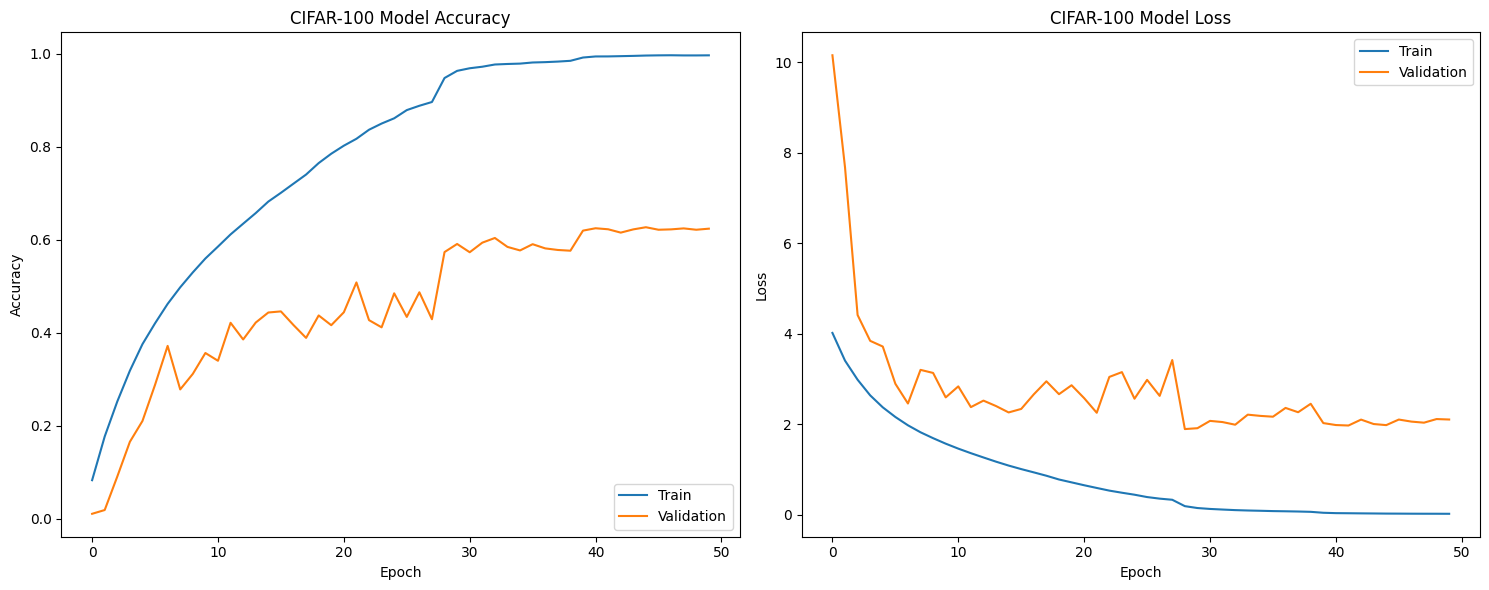

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6301 - loss: 1.9794

Test Loss: 1.9740
Test Accuracy: 0.6266
